## Вступление

**Заголовок:** Анализ факторов, влияющих на покупательскую активность клиентов Интернет-магазина "В один клик".

**Описание проекта:** В нашем распоряжении есть данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.  

**Цель исследования:** Выделить факторы, которые сильнее всего влияют на покупательскую активность клиента и разработать стратегию взаимодействия с проблемным клиентским сегментом.

**Ход исследования:** 
* Подготовка данных: загрузка и изучение общей информации из предоставленных датасетов.
* Предобработка данных: обработка пропущенных значений, корректировка типа данных, устранение дубликатов.
* Исследовательский анализ данных: изучение основных параметров объектов, их распределения, визуализация данных.
* Корреляционный анализ данных: выявление входных признаков, которые сильнее всего коррелируют с целевой переменной.
* Выбор лучшей модели машинного обучения: использование пайплайнов для масштабирования, кодирования и обучения различных моделей (Метод опорных векторов, решающие деревья, метод K-ближайших соседей, логистическая регрессия)
* Анализ важности признаков: анализ важности и влияния признаков методом SHAP-анализа.

    
**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.

## Загрузка данных

In [1]:
# загружаем все необходимые библиотеки
!pip install stringcase -q
!pip install phik -q
!pip install matplotlib==3.5.1 -q
!pip install shap --upgrade -q
!pip install scikit-learn==1.2.0 -q

import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import stringcase
import numpy as np
import shap
import sklearn
from phik import phik_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.dummy import DummyClassifier

In [2]:
# константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
# загружаем данные и проверяем успешность загрузки
try:
    df_market = pd.read_csv('/datasets/market_file.csv')
    df_market_money = pd.read_csv('/datasets/market_money.csv')
    df_market_time = pd.read_csv('/datasets/market_time.csv')
    df_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
except Exception as e:
    print(f"Произошла ошибка при открытии файла: {e}")

In [4]:
# информация о поведении покупателя на сайте
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [5]:
# информация о выручке
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [6]:
# информация о времени (в минутах), которое покупатель провёл на сайте в течение периода
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [7]:
# информация о среднемесячной прибыли продавца за последние 3 месяца
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Нам удалось подгрузить 4 таблицы и вернеуровнево ознакомиться с перечнем данных, представленных в каждой таблице.

</div>

## Предобработка данных

### Переименование столбцов

In [8]:
# переименовываем все столбцы, используя snake_case
df_market.columns = [stringcase.snakecase(col) for col in df_market.columns]
df_market_money.columns = [stringcase.snakecase(col) for col in df_market_money.columns]
df_market_time.columns = [stringcase.snakecase(col) for col in df_market_time.columns]
df_money.columns = [stringcase.snakecase(col) for col in df_money.columns]

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Мы успешно переименовали колонки во всех таблицах, используя snake_case формат.

</div>

### Удаление дубликатов

#### Утилитные функции

In [9]:
# функция для вывода уникальных значений для каждого столбца dataframe
def display_unique_values(df):
    non_numeric_columns = df.select_dtypes(exclude=['number']).columns
    for column in non_numeric_columns:
        print(f"Уникальные значения в столбце '{column}':")
        print(df[column].unique())
        print()

#### Неявные дубликаты

In [10]:
# ищем неявные дубликаты в df_market
display_unique_values(df_market)

Уникальные значения в столбце 'покупательская_активность':
['Снизилась' 'Прежний уровень']

Уникальные значения в столбце 'тип_сервиса':
['премиум' 'стандартт' 'стандарт']

Уникальные значения в столбце 'разрешить_сообщать':
['да' 'нет']

Уникальные значения в столбце 'популярная_категория':
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']



In [11]:
# избавляемся от неявных дубликатов в df_market и проверяем результат
df_market['тип_сервиса'] = df_market['тип_сервиса'].replace('стандартт', 'стандарт')
df_market['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [12]:
# ищем неявные дубликаты в df_market_money 
display_unique_values(df_market_money)

Уникальные значения в столбце 'период':
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']



In [13]:
# избавляемся от опечатки "препредыдущий_месяц"
df_market_money['период'] = df_market_money['период'].replace('препредыдущий_месяц', 'предпредыдущий_месяц')
df_market_money['период'].unique()

array(['предпредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [14]:
# ищем неявные дубликаты в df_market_time
display_unique_values(df_market_time)

Уникальные значения в столбце 'период':
['текущий_месяц' 'предыдцщий_месяц']



In [15]:
# избавляемся от опечатки "предыдцщий_месяц"
df_market_time['период'] = df_market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
df_market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Нам удалось:
- Избавиться от неявных дубликатов в `df_market['тип_сервиса']`
- Исправить опечатки в `df_market_money['период']` и `df_market_time['период']`

</div>

#### Явные дубликаты

In [16]:
# посчитаем количество явных дубликатов в df_market
print('Количество пропусков для df_market = ', df_market.duplicated().sum())
print('Количество пропусков для df_market_money = ', df_market_money.duplicated().sum())
print('Количество пропусков для df_market_time = ', df_market_time.duplicated().sum())
print('Количество пропусков для df_money = ', df_money.duplicated().sum())

Количество пропусков для df_market =  0
Количество пропусков для df_market_money =  0
Количество пропусков для df_market_time =  0
Количество пропусков для df_money =  0


<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Явных дубликатов в представленных данных не обнаружено.

</div>

### Обработка пропусков

In [17]:
# посчитаем количество пропусков в df_market
df_market.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [18]:
# посчитаем количество пропусков в df_market_money
df_market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [19]:
# посчитаем количество пропусков в df_market_time
df_market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

In [20]:
# посчитаем количество пропусков в df_money
df_money.isna().sum()

id         0
прибыль    0
dtype: int64

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Пропусков в представленных данных не обнаружено.

</div>

## Исследовательский анализ данных

### Отбор покупателей с покупательской активностью не менее трёх месяцев

In [21]:
# подсчитываем число активных месяцев для каждого покупателя 
df_all = df_market_money.groupby('id').agg(count_positive=('выручка', lambda x: (x > 0).sum())).reset_index()

# отбираем только тех, у кого было 3 активных месяца
df_active = df_all.query('count_positive == 3')

# считаем на сколько уменьшилось число покупателей после фильтрации
print('Число покупателей с покупательской активностью менее 3 месяцев = ', len(df_all) - len(df_active))
print('Число покупателей с покупательской активностью не менее 3 месяцев = ', len(df_active))

Число покупателей с покупательской активностью менее 3 месяцев =  3
Число покупателей с покупательской активностью не менее 3 месяцев =  1297


In [22]:
# убираем из всех таблиц покупателей с низкой покупательской активностью (согласно заданию проекта)
df_market = df_market[df_market['id'].isin(df_active['id'])]
df_market_money = df_market_money[df_market_money['id'].isin(df_active['id'])]
df_market_time = df_market_time[df_market_time['id'].isin(df_active['id'])]
df_money = df_money[df_money['id'].isin(df_active['id'])]

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Среди 1300 покупателей выявлено 1297 покупателей с покупательской активностью не менее 3 месяцев.
</div>

### Утилитные функции

In [23]:
# функция для отрисовки графиков (гистограмма + ящик с усами) для количественных непрерывных признаков
def plot_quantitative_histograms_and_boxplots(df, features, bins=20, figsize=(15, 10), \
                                              kde=True, color='#4CB391', title=''):        
    nrows = len(features)
    ncols = 2
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows), squeeze=False)
    
    for i, col in enumerate(features):
        sns.histplot(
            data=df,
            x=col,
            ax=axes[i, 0],
            bins=bins,
            kde=kde,
            color=color
        )
        axes[i, 0].set_title(f'Гистограмма распределения \'{col}\'', fontsize=10)
        axes[i, 0].set_xlabel(f'{col} ({features[col]})')
        axes[i, 0].set_ylabel('Количество наблюдений (шт.)')
        
        sns.boxplot(
            data=df,
            x=col,
            ax=axes[i, 1],
            color=color
        )
        axes[i, 1].set_title(f'Ящик с усами для \'{col}\'', fontsize=10)
        axes[i, 1].set_xlabel(f'{col} ({features[col]})')
    
    if(title != ''):
        fig.suptitle(title)
        
    plt.tight_layout()
    plt.show()

In [24]:
# функция для отрисовки графиков для дискретных признаков
def plot_discrete_features(df, features):
    nrows = (len(features) + 1) // 2 
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 10), squeeze=False)
    
    for ax, key in zip(axes.flat, features):
        sns.countplot(x=key, data=df, ax=ax)
        ax.set_title(f"Распределение признака {key}")
        ax.set_xlabel(f"{key} ({features[key]})")
        ax.set_ylabel("Количество наблюдений (шт.)")
      
    plt.tight_layout()
    plt.show()

In [25]:
# функция для отрисовки графиков для категориальных признаков
def plot_categorical_features(df, color='#4682B4'):
    cat_cols = df.select_dtypes(include=['object']).columns
    if cat_cols.empty:
        return
    
    fig, axes = plt.subplots(len(cat_cols), 1, figsize=(10, 3*len(cat_cols)), squeeze=False)
    
    for ax, col in zip(axes.flat, cat_cols):
        counts = df[col].value_counts()
        total = counts.sum()
        
        sns.barplot(x=counts.values, y=counts.index, ax=ax, color=color)
        ax.set_title(f'Распределение \"{col}\"', fontsize=12)
        
        for i, v in enumerate(counts):
            percentage = v / total * 100
            ax.text(v + 0.1, i, f'{v} ({percentage:.1f}%)', va='center', ha='left', fontsize=10)
    
    plt.tight_layout()
    plt.show()

### Поведение покупателя

#### Количественные признаки

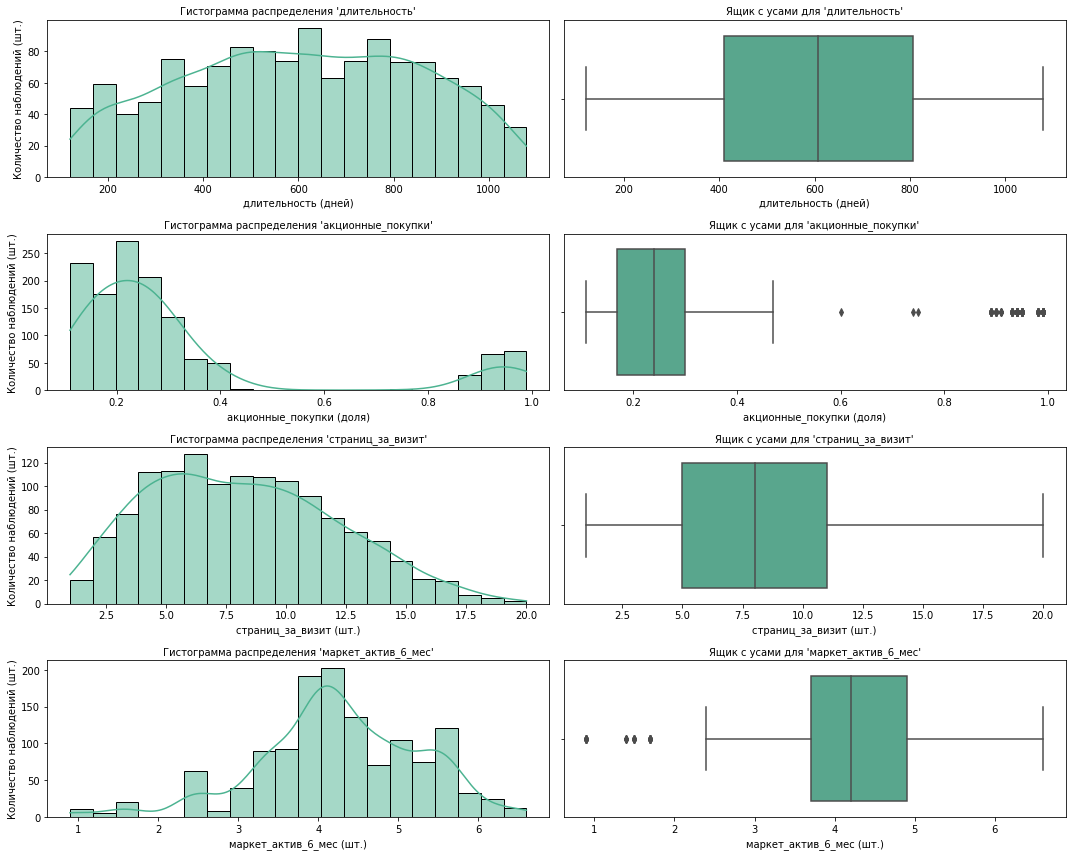

In [26]:
# единицы измерения для непрерывных признаков
features = {
    "длительность": "дней",
    "акционные_покупки": "доля",
    "страниц_за_визит": "шт.",
    "маркет_актив_6_мес": "шт."
}

# отобразим графики для количественных признаков
plot_quantitative_histograms_and_boxplots(df_market, features)

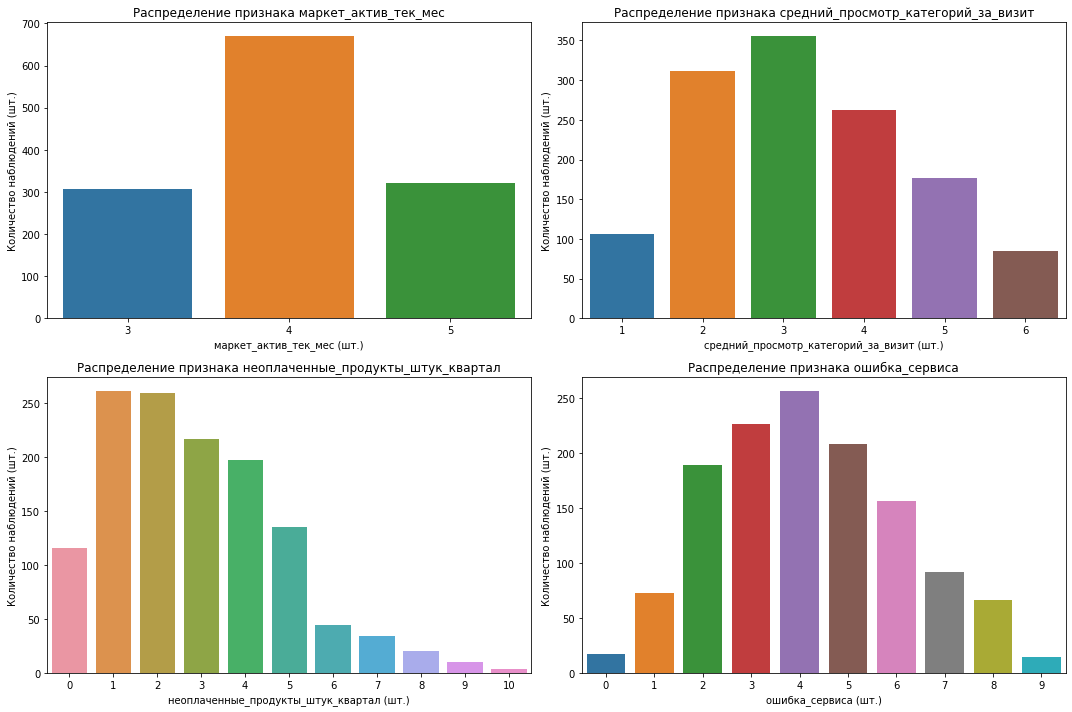

In [27]:
# единицы измерения для дискретных признаков
features = {
    "маркет_актив_тек_мес": "шт.",
    "средний_просмотр_категорий_за_визит": "шт.",
    "неоплаченные_продукты_штук_квартал": "шт.",
    "ошибка_сервиса": "шт.",
}

plot_discrete_features(df_market, features)

In [28]:
# отобразим описательную статистику для df_market
df_market.drop('id', axis=1).describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,4.254433,4.009252,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584
std,1.015618,0.696048,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061
min,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000


<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Из графиков и описательной статистики по количественным данным о поведении покупателя можно выделить следующие моменты:
1. На клиентов за последние 6 месяцев приходилось в среднем 4,25 коммуникаций (рассылок, звонков, показов рекламы) в месяц.
2. Есть 4 клиента, с которыми в среднем общались несколько меньше чем с другими клиентами (см. график "Ящик с усами для `маркет_актив_6_мес`"
3. В текущем месяце число коммуникаций с каждый клиентом было равно 4, за исключением 2 клиентов (см. график "Ящик с усами для `маркет_актив_тек_мес`" 
4. Средний возраст нашего клиента = 602 дня с момента регистрации на сайте.
5. Самому "старому" клиенту 1079 дней. 
6. За последние 6 месяцев средний показатель доли акционных покупок составляет чуть менее 32%, а медианный показатель - 24%. 
7. Есть 8 клиентов, которые совершают в подавляющем большинстве случаев акционные покупки (вплоть до 99% покупок) - см. выбросы на графике "Ящик с усами для `акционные_покупки`"  
8. За визит на сайт "средний" покупатель просматривал 3 категории в течение последнего месяца.
9. В среднем за последний квартал в корзине покупателя за последние 3 месяца было 3 неоплаченных продукта, но есть покупатели, у которых количество неоплаченных продуктов в корзине доходило до 10 (см. график "Ящик с усами для `неоплаченные_продукты_штук_квартал`". 
10. За последние 3 месяца среднее количество страниц, которое просмотрел "медианный" покупатель за один визит на сайт = 8 страниц.

</div>

#### Категориальные признаки

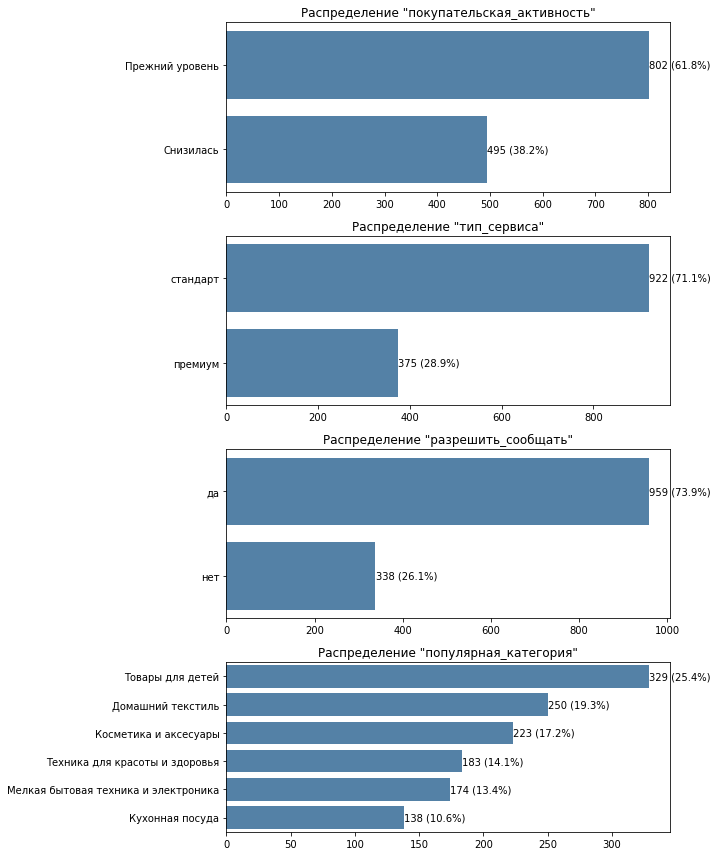

In [29]:
plot_categorical_features(df_market)

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Из графиков категориальных признаков поведения покупателя можно выделить следующие моменты:
1. Покупательская активность снизилась у 498 покупателей (38,2%).
2. Доля покупателей, пользующихся сервисом "стандарт" - 71,1%. Остальные 28,9% используют "премиум" сервис.
3. Дали согласие на получение дополнительной информации о новых товарах 73,9% покупателей.
4. Среди покупателей самая популярная категория товаров - "товары для детей" (25,4%).
5. Самая непопулярная категория товаров - кухонная посуда (10,6%).
    
</div>

### Выручка

In [30]:
# отбираем данные для каждого периода 
df_prev_prev_month = df_market_money.query('период == "предпредыдущий_месяц"')
df_prev_month = df_market_money.query('период == "предыдущий_месяц"')
df_current_month = df_market_money.query('период == "текущий_месяц"')

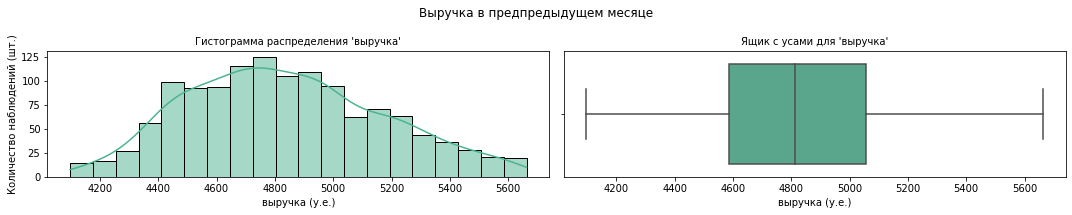

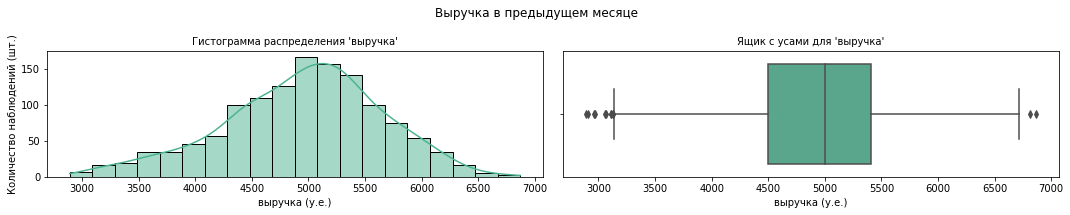

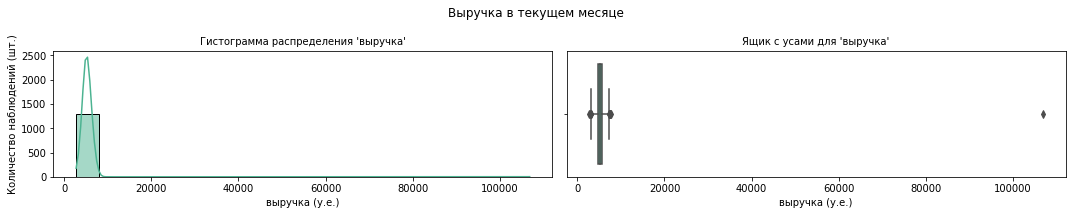

In [31]:
features = {
    "выручка": "у.е.",
}

plot_quantitative_histograms_and_boxplots(df_prev_prev_month, features, title='Выручка в предпредыдущем месяце')
plot_quantitative_histograms_and_boxplots(df_prev_month, features, title='Выручка в предыдущем месяце')
plot_quantitative_histograms_and_boxplots(df_current_month, features, title='Выручка в текущем месяце')

In [32]:
# узнаем id покупателя с выбросом по выручке
df_current_month.query('выручка > 100000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [33]:
# удаляем его из всех таблиц
df_market = df_market[df_market['id'] != 215380]
df_market_money = df_market_money[df_market_money['id'] != 215380]
df_market_time = df_market_time[df_market_time['id'] != 215380]
df_money = df_money[df_money['id'] != 215380]
df_current_month = df_current_month[df_current_month['id'] != 215380]

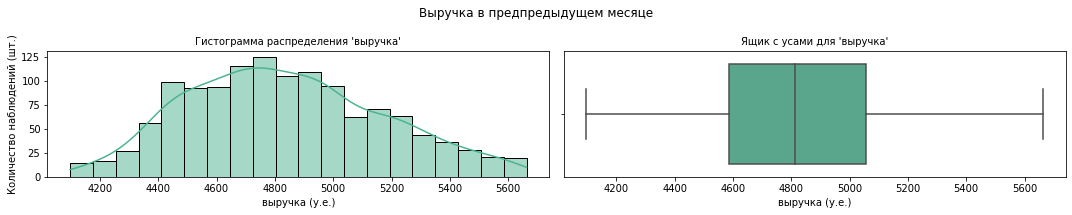

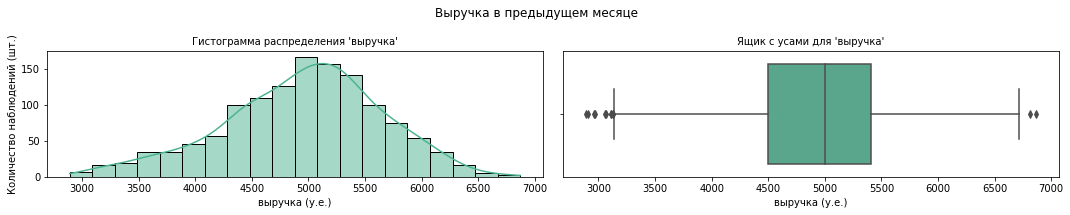

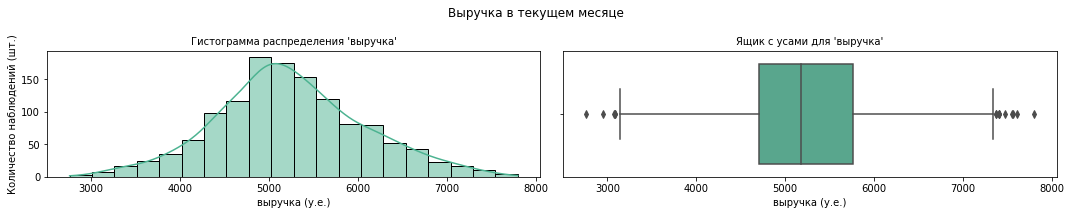

In [34]:
features = {
    "выручка": "у.е.",
}

plot_quantitative_histograms_and_boxplots(df_prev_prev_month, features, title='Выручка в предпредыдущем месяце')
plot_quantitative_histograms_and_boxplots(df_prev_month, features, title='Выручка в предыдущем месяце')
plot_quantitative_histograms_and_boxplots(df_current_month, features, title='Выручка в текущем месяце')

In [35]:
describe_data = [
    ('Предпредыдущий месяц', df_prev_prev_month.drop('id', axis=1).describe().loc[['min', '50%', 'max', 'mean']]),
    ('Предыдущий месяц', df_prev_month.drop('id', axis=1).describe().loc[['min', '50%', 'max', 'mean']]),
    ('Текущий месяц', df_current_month.drop('id', axis=1).describe().loc[['min', '50%', 'max', 'mean']])
]

data_dict = {}
for name, data in describe_data:  
    data_dict[name] = data

result = pd.concat(data_dict, axis=1)
print(result)

     Предпредыдущий месяц Предыдущий месяц Текущий месяц
                  выручка          выручка       выручка
min           4098.000000       2890.00000   2758.700000
50%           4812.000000       5005.50000   5179.950000
max           5663.000000       6869.50000   7799.400000
mean          4836.367772       4948.33963   5238.096065


<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

1. В ходе исследовательского анализа по выручке было выявлено наличие покупателя со статистическим выбросом в текущем месяце (выручка более 100 тыс. условных единиц) - было принято решение убрать этого покупателя из всех таблиц, чтобы не искажать результаты исследования.
2. В среднем компания получает около 5000 условных единиц в месяц на покупателя.

    
</div>

### Время на сайте

In [36]:
df_prev_month = df_market_time.query('период == "предыдущий_месяц"')
df_current_month = df_market_time.query('период == "текущий_месяц"')

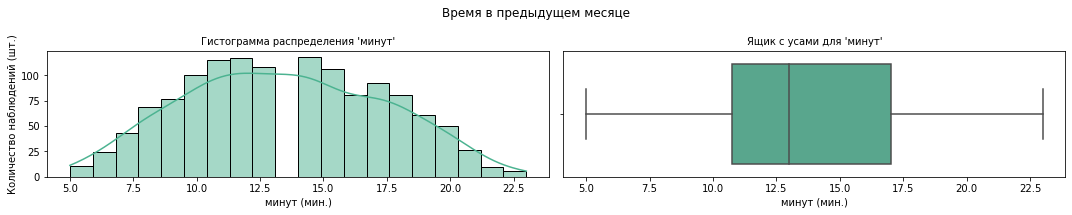

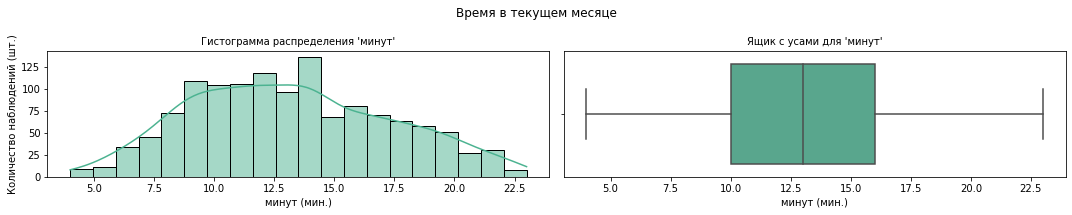

In [37]:
features = {
    "минут": "мин.",
}

plot_quantitative_histograms_and_boxplots(df_prev_month, features, title='Время в предыдущем месяце')
plot_quantitative_histograms_and_boxplots(df_current_month, features, title='Время в текущем месяце')

In [38]:
describe_data = [
    ('Предыдущий месяц', df_prev_month.drop('id', axis=1).describe().loc[['min', '50%', 'max', 'mean']]),
    ('Текущий месяц', df_current_month.drop('id', axis=1).describe().loc[['min', '50%', 'max', 'mean']])
]

data_dict = {}
for name, data in describe_data:  
    data_dict[name] = data

result = pd.concat(data_dict, axis=1)
print(result)

     Предыдущий месяц Текущий месяц
                минут         минут
min          5.000000      4.000000
50%         13.000000     13.000000
max         23.000000     23.000000
mean        13.470679     13.210648


<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Среднестатистический покупатель проводит на сайте около 13 минут.

</div>

### Прибыль

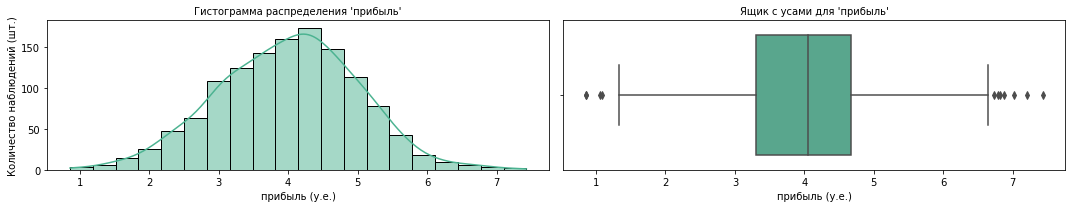

In [39]:
features = {
    "прибыль": "у.е.",
}

plot_quantitative_histograms_and_boxplots(df_money, features)

In [40]:
df_money.drop('id', axis=1).describe().loc[['min', '50%', 'max', 'mean']]

,прибыль
min,0.860000
50%,4.045000
max,7.430000
mean,3.997701


<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

1. Среднемесячная прибыль от среднестатистического клиента составляет около 4 условных единиц.
2. Есть несколько клиентов, которые менее прибыльные чем остальные клиенты - они приносят около 1 у.е. в месяц.
3. Также есть несколько клиентов, которые приносят большее количество прибыли - около 7 у.е.

</div>

## Объединение таблиц

In [41]:
df_market_money_pivot = df_market_money.pivot_table(index='id', columns='период', values='выручка').reset_index()
df_market_money_pivot = df_market_money_pivot.rename(columns={
'предпредыдущий_месяц': 'выручка_предпредыдущий_месяц',
    'предыдущий_месяц': 'выручка_предыдущий_месяц',
        'текущий_месяц': 'выручка_текущий_месяц'
    })

df_market_time_pivot = df_market_time.pivot_table(index='id', columns='период', values='минут').reset_index()
df_market_time_pivot = df_market_time_pivot.rename(columns={
    'предыдущий_месяц': 'минут_предыдущий_месяц',
        'текущий_месяц': 'минут_текущий_месяц'
    })

print(f"Размер df_market={df_market.shape}")
print(f"Размер df_market_money_pivot={df_market_money_pivot.shape}")
print(f"Размер df_market_time_pivot={df_market_time_pivot.shape}")

df = df_market.merge(df_market_money_pivot, on='id', how='inner').merge(df_market_time_pivot, on='id', how='inner')
print(f"Размер df={df.shape}")
df.head(3)

Размер df_market=(1296, 13)
Размер df_market_money_pivot=(1296, 4)
Размер df_market_time_pivot=(1296, 3)
Размер df=(1296, 18)


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13


<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Таблицы `df_market`, `df_market_money`, `df_market_time` успешно объединены в один dataframe `df`.

</div>

## Корреляционный анализ

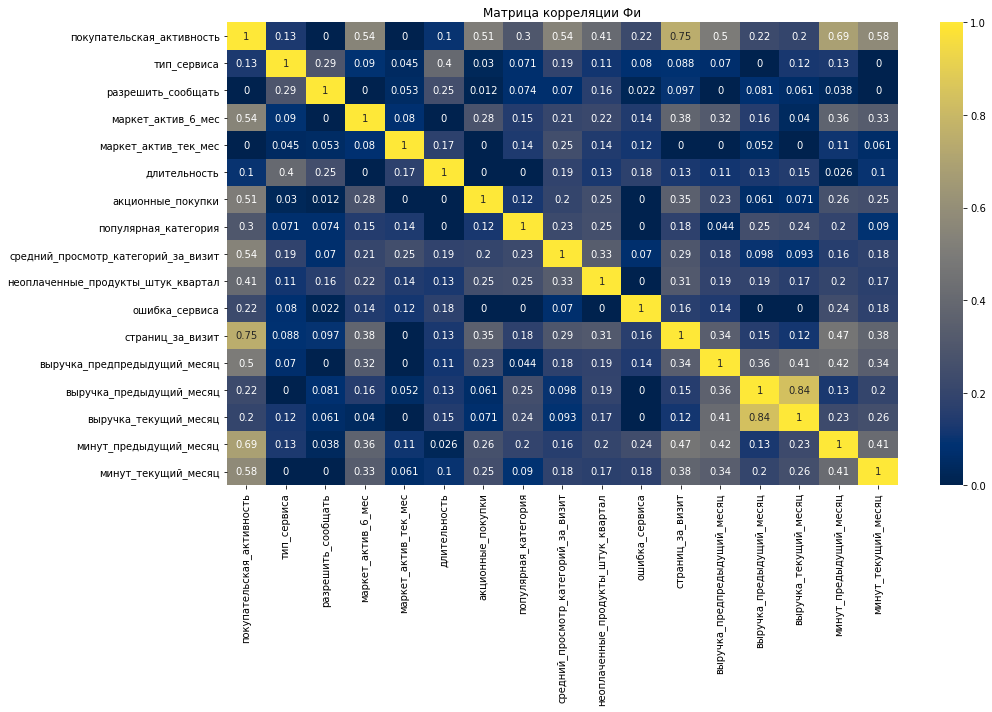

In [42]:
# построим матрицу корреляции Фи
df = df.set_index('id')
plt.figure(figsize=(15, 10))  
interval_cols=[
    'маркет_актив_6_мес',
    'длительность',
    'акционные_покупки',
    'выручка_предпредыдущий_месяц',
    'выручка_предыдущий_месяц',
    'выручка_текущий_месяц',
    'минут_предыдущий_месяц',
    'минут_текущий_месяц'
]
phi_matrix = df.phik_matrix(interval_cols)
sns.heatmap(phi_matrix, annot=True, cmap='cividis')  

plt.title('Матрица корреляции Фи')
plt.tight_layout()
plt.show()

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

По данным корреляционного анализа можно сделать следующие выводы:
1. Целевой признак `покупательская_активность` больше всего коррелирует с признаком `страниц_за_визит`, `минут_предыдущий месяц` и `минут_текущий_месяц`, что в общем-то логично - если пользователь проводит много времени на сайте, то скорее всего он что-то хочет купить.
2. Целевой признак `покупательская_активность` меньше всего коррелирует с признаками `разрешить_сообщать`, `маркет_актив_тек_мес`, `длительность` и `тип_сервиса`. Все эти признаки (кроме `маркет_актив_тек_мес`) мало связаны с покупательской активностью. А вот касательно `маркет_актив_тек_мес` все интереснее - есть очень похожий признак `маркет_актив_6_мес`, который коррелирует с целевой переменной гораздо больше. Из этого можно сделать вывод, что маркетинговые мероприятия в текущем месяце еще не успели повлиять на покупательскую активность наших клиентов.
3. Между признаками `выручка_предыдущий_месяц` и `выручка_текущий_месяц` наблюдается высокая корреляция (Фи = 0.84), что может указывать на мультиколлинеарность. Однако мы сохраняем оба признака, так как они имеют разный логический смысл. 

</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
        <font color='4682B4'>Спасибо за информацию! Буду изучать.</font>
</div>

## Использование пайплайнов

In [43]:
# кодируем целевой признак при помощи LabelEncoder
le = LabelEncoder()
le.fit(df['покупательская_активность'])
le.classes_ = np.array(['Прежний уровень', 'Снизилась'])
df['покупательская_активность'] = le.transform(df['покупательская_активность'])

In [ ]:
%%time

X_train, X_test, y_train, y_test = train_test_split(
    df.drop('покупательская_активность', axis=1),
    df['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['покупательская_активность']
)

print(f"Размерность тренировочной выборки {X_train.shape}")
print(f"Размерность тестовой выборки {X_test.shape}")

ohe_columns = ['популярная_категория', 'разрешить_сообщать']
ord_columns = ['тип_сервиса']
num_columns = [
   'маркет_актив_6_мес',
   'маркет_актив_тек_мес',
   'длительность',
   'акционные_покупки',
   'средний_просмотр_категорий_за_визит',
   'неоплаченные_продукты_штук_квартал',
   'ошибка_сервиса',
   'страниц_за_визит',
   'выручка_предпредыдущий_месяц',
   'выручка_предыдущий_месяц',
   'выручка_текущий_месяц',
   'минут_предыдущий_месяц',
   'минут_текущий_месяц'
]

ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'ord', 
            OrdinalEncoder(categories=[['стандарт', 'премиум']], \
                           handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)



data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [3, 7, 12],
        'models__max_features': [2, 7, 12],
        'models__min_samples_split': [2, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 15, 2),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': [0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10, 100],
        'models__gamma': [0.001, 0.01, 0.1, 1],
        'models__kernel': ['linear', 'rbf'],
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10, 100],
        'models__kernel': ['poly'],
        'models__degree': [2, 3, 4]
    }
    
]

grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика ROC-AUC лучшей модели при кросс-валидации на тренировочной выборке:', grid_search.best_score_)

y_test_pred = grid_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Размерность тренировочной выборки (972, 16)
Размерность тестовой выборки (324, 16)
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                             

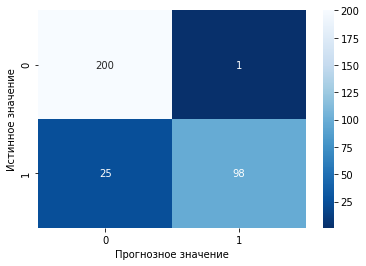

In [45]:
# строим confusion 
y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Истинное значение')
plt.xlabel('Прогнозное значение'); 

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Мы применили пайплайн для поиска лучшей модели машинного обучения и ее гиперпараметров - в итоге были получены следующие результаты:
1. Лучшая модель - SVC (метод опорных векторов) с гиперпараметрами:
    - `С=1` (параметр регуляризации)
    - `gamma=0.1` (параметр модели для ядра RBF)
2. В качестве скейлера при подготовке входных данных был выбран MinMaxScaler.
3. Итоговая метрика работы модели на тренировочной выборке (roc-auc) =~ 0,90
4. Итоговая метрика работы модели на тестовой выборке (roc-auc) =~ 0,92
    
Также мы построили Confusion Matrix для того, чтобы определить где чаще ошибается модель. В результате имеем следующие результаты из 324 предсказаний: 
- FN = 25
- FP = 1

    Модель однажды ошиблась, что у клиента снизилась покупательская активность и 25 раз ошиблась, что у клиента не снизилась покупательская активность.
</div>

## Анализ важности признаков

PermutationExplainer explainer: 325it [01:28,  3.39it/s]                         


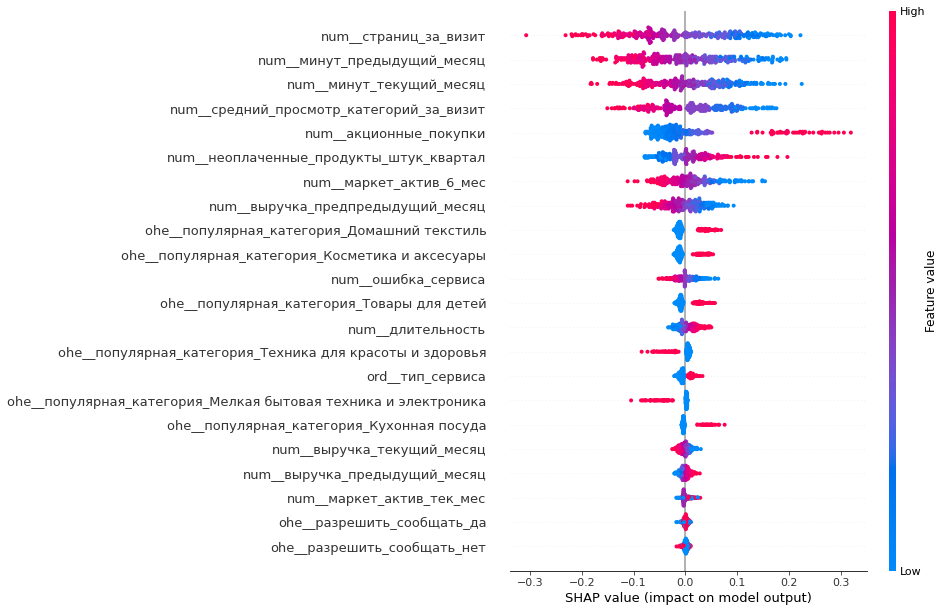

CPU times: user 1min 26s, sys: 700 ms, total: 1min 26s
Wall time: 1min 29s


In [46]:
%%time
# Получим лучшие processor и model
processor = grid_search.best_estimator_.named_steps['preprocessor']
model = grid_search.best_estimator_.named_steps['models']

# Получим преобразованные X_train и X_test
col_names = processor.get_feature_names_out()
X_train_processed = pd.DataFrame(processor.transform(X_train), columns=col_names)
X_test_processed = pd.DataFrame(processor.transform(X_test), columns=col_names)

# Для инициализации алгоритма shap берем 30 фоновых точек тренировочной выборки
explainer = shap.Explainer(model.predict_proba, shap.sample(X_train_processed.values, 30))

# Получаем shap-значения для наблюдений из тестовой выборки и рисуем таблицу признаков и их shap-значений
shap_values = explainer(X_test_processed)
shap.plots.beeswarm(shap_values[:, :, 1], max_display=25)

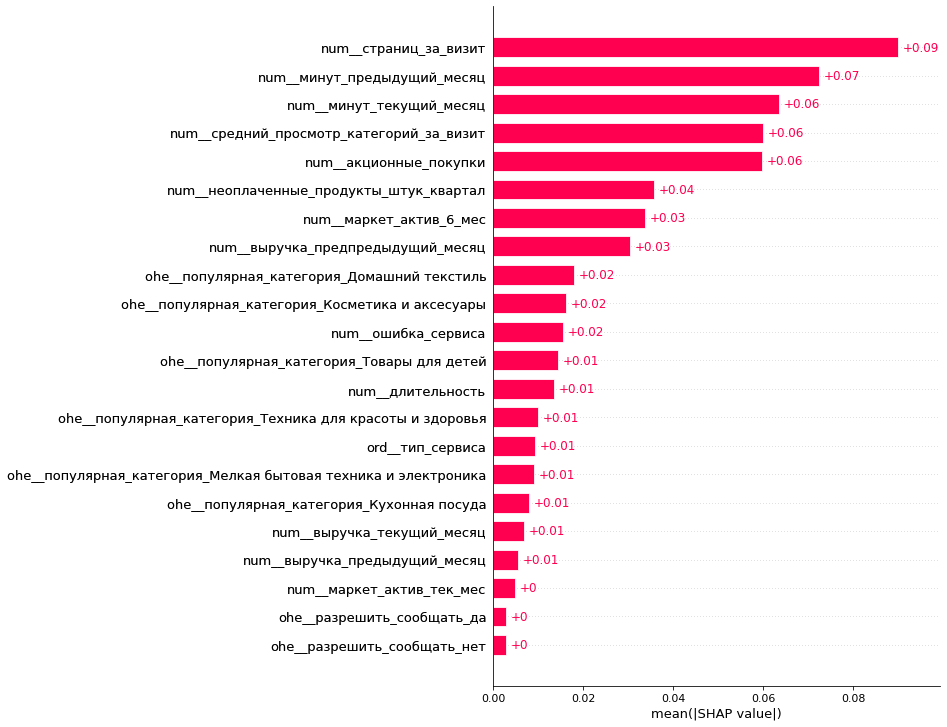

In [47]:
shap.plots.bar(shap_values[:,:,1], max_display=25)

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Проведенный SHAP-анализ позволил сделать некоторые выводы о важности признаков в контексте их влияния на целевую переменную `"Покупательская активность"`.
    
Значимые признаки 
1. Признак `"Страниц за визит"` (среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца) - наиболее значимый признак. С точки зрения здравого смысла это очень логично, ведь чем больше страниц на сайте просматривают наши клиенты, тем больше товаров им требуется и тем больше покупок они совершат. 
2. По той же логике можно судить почему значимыми являются признаки `Минут за предыдущий месяц`, `Минут за текущий месяц` - данные признаки говорят об активности клиента на сайте.
3. Значимость признака `Средний просмотр категорий за визит` также легко объясняется, ведь чем более разнообразные товары приобретает клиент, тем выше его удовлетворенность качеством сервиса в целом.
4. Более интересным является влияние на целевую переменную признака `Акционные покупки` - чем выше доля акционных покупок клиента (среди всех покупок), тем выше вероятность, что `"Покупательская активность"` клиента снизится. Данное наблюдение говорит нам о том, что клиенты с высокой долей покупок по акциям скорее всего не станут у нас ничего покупать при отсутствии скидок.  

Слабозначимые признаки 
1. Признак `"Маркетинговая активность в текущем месяце"` мало влияет на целевой признак `"Покупательская активность"` - вероятно, по причине того, что маркетинговые коммуникации еще не успели повлиять на наших клиентов (т.к. значимость признака `"Среднемесячная маркетинговая активность за 6 месяцев"` выше). 
2. Также малозначимыми являются признаки `"Разрешить сообщать"` и `"Тип сервиса"`.
    
Рекомендации
1. Упростить модель прогнозирования путем исключения признаков, которые слабо влияют на значение целевой переменной (`"Маркетинговая активность в текущем месяце"`, `"Разрешить сообщать"` и `"Тип сервиса"`).
2. Сегментировать клиентов по поведению (активные, неактивные, "акционные") и для каждого из сегментов выработать стратегию взаимодействия.

</div>




## Сегментация покупателей

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

В качестве целевого сегмента выберем клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

Стратегическая цель по работе с такими клиентами - снизить долю акционных покупок, не потеряв при этом в их количестве. 
    
</div>

In [ ]:
df_segment = df.query('покупательская_активность == 1 and акционные_покупки > 0.5')

print(f'Количество покупателей с долей акционных покупок \
более 50% и сниженной покупательской активностью - {len(df_segment)}')

print(f'Доля покупателей с долей акционных покупок более 50% \
и сниженной покупательской активностью - {len(df_segment) / len(df):.1%}')

percent = df_money[df_money['id'].isin(df_segment.index)]['прибыль'].sum() / df_money['прибыль'].sum()
print(f'Доля прибыли, которую приносят данные покупатели - {percent:.1%}')

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Статистика по "акционным" покупателям:
1. Количество - 133 покупателя
2. Доля - 10.3%
3. Доля от прибыли - 9.9%
</div>

In [ ]:
# выделяем слабозначимые признаки и избавляемся от них
weak_features = ['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_тек_мес', 'выручка_предыдущий_месяц', \
                'выручка_текущий_месяц','выручка_предпредыдущий_месяц', 'ошибка_сервиса', 'длительность']
df_segment = df_segment.drop(weak_features, axis=1)

In [ ]:
# единицы измерения для непрерывных признаков
features = {
    "маркет_актив_6_мес": "шт.",
}

# отобразим графики для количественных признаков
plot_quantitative_histograms_and_boxplots(df_segment, features)

In [ ]:
# единицы измерения для дискретных признаков
features = {
    "акционные_покупки": "доля",
    "средний_просмотр_категорий_за_визит": "шт.",
    "неоплаченные_продукты_штук_квартал": "шт.",
    "страниц_за_визит": "шт.",
    "минут_предыдущий_месяц": "мин.",
    "минут_текущий_месяц": "мин."
}

plot_discrete_features(df_segment, features)

In [ ]:
df_segment.drop('покупательская_активность', axis=1).describe()

In [ ]:
plot_categorical_features(df_segment.drop('покупательская_активность', axis=1))

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Исходя из графического и аналитического анализа датасета "акционных" покупателей можно выделить следующее:
1. В среднем за 1 посещение сайта такие покупатели просматривают на 1 категорию меньше по сравнению с обычными покупателями.
2. Данные покупатели проводят на сайте в среднем на 3 минуты меньше обычных покупателей.
3. Данные покупатели посещают в 2 раза меньше страниц чем обычные покупатели (4 страницы у "акционных" против 8 страниц у обычных).
    
Предложения по работе с данными клиентами:
1. Повысить вовлеченность на сайте - например, предлагать скидки при покупке нескольких товаров из различных категорий.
2. Добавить "цепляющий" контент (видеообзоры товаров, отзывы о товарах, сравнение товаров).
3. Стимулировать повторные покупки без акций (например, предлагать подписку на премиум-сервис при покупке определенного количества товаров).
4. Постепенно снижать зависимость покупателей от скидок (уменьшать размер скидок, ввести накопительные баллы, заменить скидки на альтернативные стимулы).
</div>

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

## Итоговые выводы

---

### Выводы для заказчика

1. Выделены наиболее важные факторы, влияющие на покупательскую активность клиентов интернет-магазина "В один клик": 
- среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца
- среднее количество времени, которое покупатель проводит на сайте 
- среднее количество категорий, которое покупатель просматривал в течении месяца
- доля акционных покупок среди всех покупок, которые совершил покупатель
2. Маркетинговая активность, как фактор, оказался не столь значимым с точки зрения влияния на покупательскую активность - возможно, необходимо поменять маркетинговую политику или сделать ряд кадровых изменений в отделе маркетинга.
3. Было выявлено, что тип сервиса совсем никак не влияет на покупательскую активность - вероятно, наличие премиум-сервиса никак не стимулирует покупателей совершать покупки.   
4. В ходе исследования в качестве одного из проблемных сегментов был выделен сегмент "акционных" покупателей - клиентов, у которых доля покупок со скидкой стремится к 100% и у которых при этом снижается покупательская активность. 
5. Анализ данных по "акционным" покупателям показал, что данные покупатели приносят 10% всей прибыли интернет-магазина.
6. Была выработана стратегия по удержанию покупательской активности среди данных клиентов:
- Повысить вовлеченность на сайте - например, предлагать скидки при покупке нескольких товаров из различных категорий.
- Добавить "цепляющий" контент (видеообзоры товаров, отзывы о товарах, сравнение товаров).
- Стимулировать повторные покупки без акций (например, предлагать подписку на премиум-сервис при покупке определенного количества товаров).
- Постепенно снижать зависимость покупателей от скидок (уменьшать размер скидок, ввести накопительные баллы, заменить скидки на альтернативные стимулы).


---

### Технические выводы по проекту

Работа с данными:
- Нам удалось избавиться от неявных дубликатов и исправить опечатки во входных данных.
- Пропусков во входных данных обнаружено не было.
- Среди 1300 покупателей, представленных во входных данных, было выявлено 1297 покупателей с покупательской активностью не менее 3 месяцев.
- В ходе исследовательского анализа по выручке было выявлено наличие покупателя со статистическим выбросом в текущем месяце (выручка более 100 тыс. условных единиц) - было принято решение убрать этого покупателя из всех таблиц, чтобы не искажать результаты исследования.

Корреляционный анализ:
- Было обнаружено, что целевой признак "Покупательская активность" сильнее всего коррелирует с признаками:
  - Среднее количество страниц за визит (0.75)
  - Количество минут, проведенных на сайте в предыдущем месяце (0.69)
  - Количество минут, проведенных на сайте в текущем месяце (0.58)

Обучение моделей:
- Была найдена лучшая модель машинного обучения с использованием пайплайнов - лучшей моделью оказалась модель SVC (метод опорных векторов) с гиперпараметрами:
    - С=1 (параметр регуляризации)
    - gamma=0.1 (параметр модели для ядра RBF)
- Итоговая метрика работы модели на тестовой выборке (roc-auc) =~ 0.92
    
Анализ важности признаков:
- При помощи SHAP-анализа были выявлены факторы, которые сильно влияют на целевой признак:
    - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца (0.09)
    - среднее количество времени, которое покупатель провел на сайте в предыдущем месяце (0.07)
    - среднее количество времени, которое покупатель провел на сайте в текущем месяце (0.06)
    - среднее количество категорий, которое покупатель просматривал в течении месяца (0.06)
    - доля акционных покупок среди всех покупок, которые совершил покупатель (0.06)


</div>
